In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import ta

In [26]:
# 1. 데이터 로딩 및 기술적 지표 추가
filename = 'sp500_stocks/SBUX.csv'  # 예시 종목 

# 데이터 로딩
df = pd.read_csv(filename)
df = df.dropna()

# 기술적 지표 추가
df['MA20'] = ta.trend.sma_indicator(df['Close'], window=20)
bb = ta.volatility.BollingerBands(df['Close'], window=20, window_dev=2)
df['Upper'] = bb.bollinger_hband()
df['Lower'] = bb.bollinger_lband()
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

# 결측치 제거
df.dropna(inplace=True)
df.tail()


,Date,Open,High,Low,Close,Volume,MA20,Upper,Lower,RSI
2511,2023-12-22,92.356712,92.889841,91.445550,91.978679,6360400.0,95.022341,98.996662,91.048020,34.898864
2512,2023-12-26,92.734741,92.754132,92.046526,92.414864,3709500.0,94.685502,98.331176,91.039828,37.495533
2513,2023-12-27,92.366409,92.841374,91.881750,92.754138,4959300.0,94.381621,97.579947,91.183294,39.516364
2514,2023-12-28,92.986771,93.025544,92.191929,92.569963,4518300.0,94.090340,96.796622,91.384058,38.783322
2515,2023-12-29,93.064323,93.393888,92.424569,92.938307,6134000.0,93.887753,96.284327,91.491178,41.135201


In [ ]:
# 2. 정규화 및 데이터 준비
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA20', 'Upper', 'Lower', 'RSI']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

sequence_length = 50

X, y = [], []
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i+sequence_length])
    y.append(scaled_data[i+sequence_length][features.index('Close')])

X = np.array(X)
y = np.array(y)

# 3. 훈련/테스트 분리
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 4. 모델 구성
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# 5. 학습
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_split=0.2, callbacks=[early_stop], verbose=1)

# 6. 예측 및 역변환
pred = model.predict(X_test)

close_index = features.index('Close')

# 예측값 및 실제값을 Close 위치에 삽입
y_full = np.zeros((len(y_test), len(features)))
pred_full = np.zeros((len(pred), len(features)))
y_full[:, close_index] = y_test
pred_full[:, close_index] = pred.flatten()

true_rescaled = scaler.inverse_transform(y_full)[:, close_index]
pred_rescaled = scaler.inverse_transform(pred_full)[:, close_index]

Epoch 1/50


c:\Users\pyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0383 - val_loss: 0.0056
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0038 - val_loss: 0.0070
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0035 - val_loss: 0.0080
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0026 - val_loss: 0.0050
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0023 - val_loss: 0.0079
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0022 - val_loss: 0.0040
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0021 - val_loss: 0.0050
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016 - val_loss: 0.0045
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


MSE: 14.10, MAE: 3.06, sMAPE: 3.43%


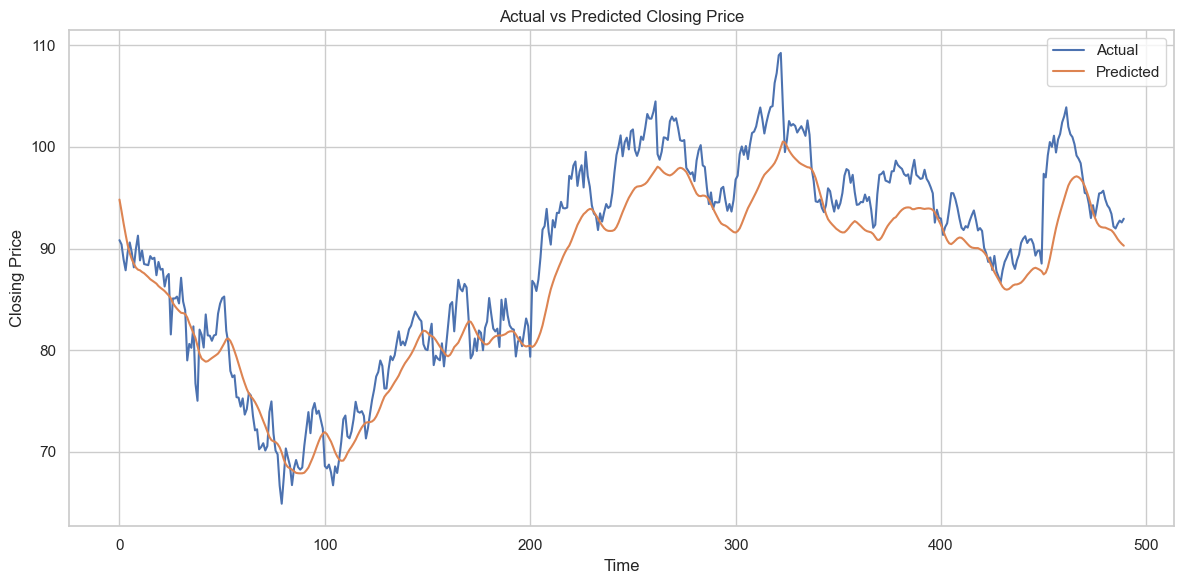

가장 최근 실제 종가: 92.94
가장 최근 예측 종가: 90.28


In [28]:
# 7. 평가 지표 출력
def smape(a, f):
    return 100/len(a) * np.sum(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

mse = mean_squared_error(true_rescaled, pred_rescaled)
mae = mean_absolute_error(true_rescaled, pred_rescaled)
smape_val = smape(true_rescaled, pred_rescaled)

print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, sMAPE: {smape_val:.2f}%")

# 8. 시각화
plt.figure(figsize=(12, 6))
plt.plot(true_rescaled, label='Actual')
plt.plot(pred_rescaled, label='Predicted')
plt.title('Actual vs Predicted Closing Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. 가장 최근 예측값 출력
print(f"가장 최근 실제 종가: {true_rescaled[-1]:.2f}")
print(f"가장 최근 예측 종가: {pred_rescaled[-1]:.2f}")